<a href="https://colab.research.google.com/github/misbahsy/FourthBrain/blob/main/MisbahSyed_Machine_Learning_Engineer_Walmart_Labs_Inventory_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Today you are a Machine Learning Engineer at the Department of Marketing and Inventory @Walmart Labs.
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store

This work is motivated by the publication https://arxiv.org/pdf/2102.01625.pdf

Further details on data processing available at:
https://arxiv.org/pdf/2010.02503.pdf

## You have access to the Walmart server data, specifically the Electronics section, such that you have NO customer facing information, but, only access to timestamped data regarding product viewing/carting/purchasing as follows.


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Replace the ID with ID of file you want to access
X_train = drive.CreateFile({'id':'1KuUZHEIYzMlJCEJIjBJaQ_01Lr5atxwI'}) 
X_train.GetContentFile('X_train.csv') 
X_test = drive.CreateFile({'id':'1XSjXd1DNnkz2Lhn1BefEF9bsVE-gAvw9'}) 
X_test.GetContentFile('X_test.csv') 

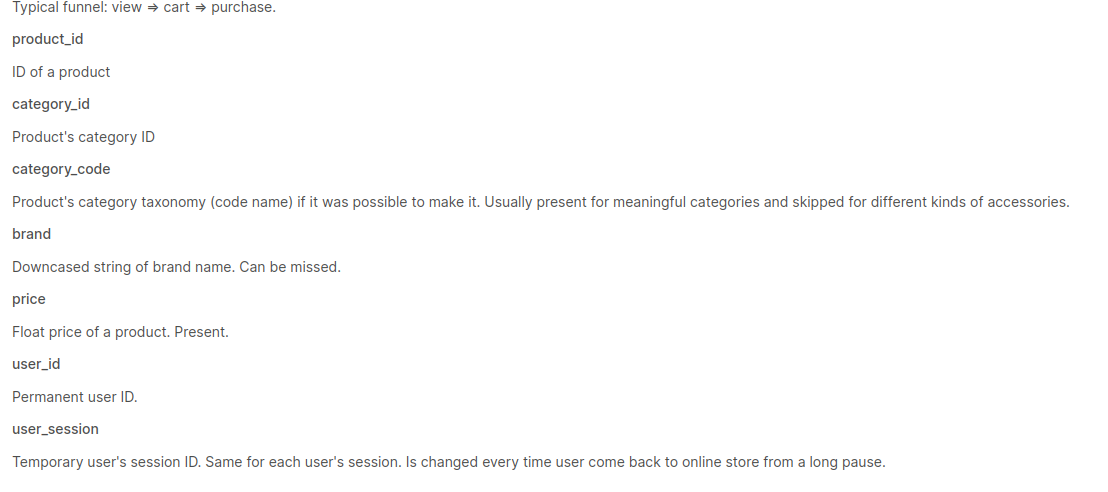

In [ ]:
from IPython.display import Image
Image(filename='image1.png')

## The first step is to convert session level information to User-journey level data, i.e. track time stamps from a particulat userID-Product ID combination over time to see if the combination results in a purchase (Y=1) or not (Y=0). The user journey level features extracted for this data set looks as follows:

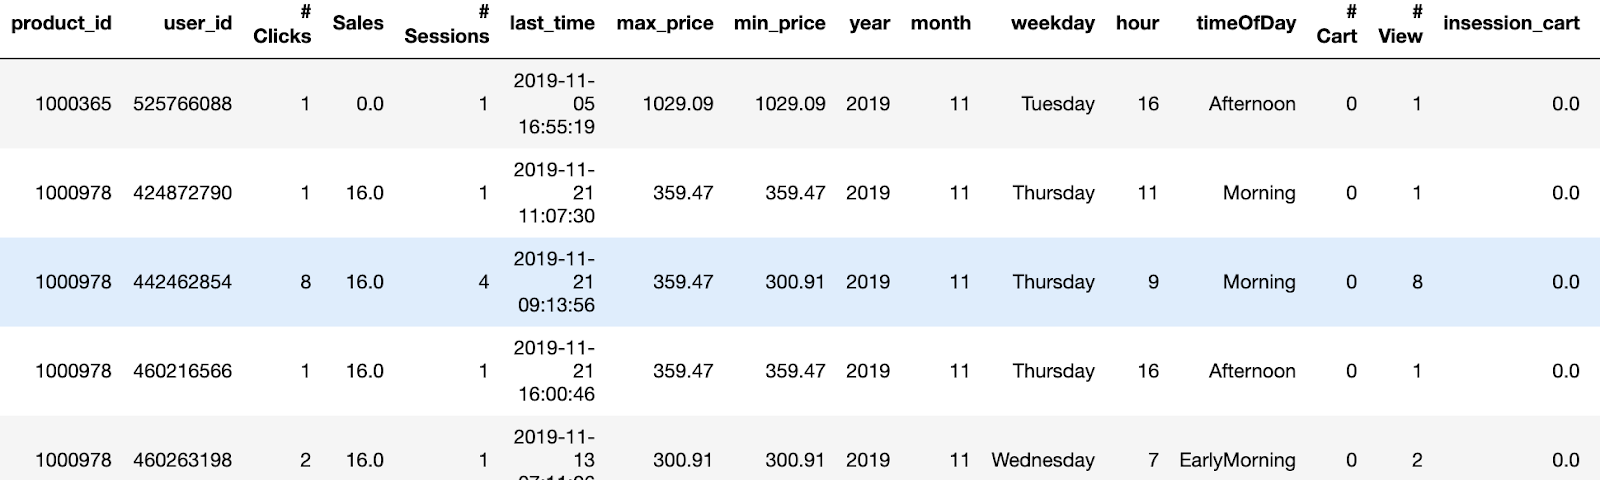

In [ ]:
Image(filename='image10.png')

## You have access to user journey level data. Your goal is to perform the following:
## A. To identify what features are most important to classify purchasing customers from non-purchasing customers
## B. To predict a purchasing customer-product interaction from a no-purchasing one. The goal is to build the "best" data model with regards to Recall and F1-score.

## Task 0 (Initialization): Understand the Data!

In [ ]:
## Importing required Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns

### Read in the training data, print its shape, and display its first few rows

In [ ]:
### START CODE HERE ###
X_train = pd.read_csv('./X_train.csv')
print(X_train.shape)
X_train.head(10)
### END CODE HERE ###

(645816, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0
5,1,1,0.0,244.54,244.54,0,1,0,1,2019,11,Sat,Noon,0,0
6,1,1,0.0,234.24,234.24,0,1,0,1,2019,11,Sat,Morning,0,0
7,1,1,0.0,463.31,463.31,0,1,0,1,2019,11,Wed,Evening,0,0
8,1,1,0.0,253.25,253.25,0,1,0,1,2019,11,Thu,Afternoon,0,0
9,1,1,0.0,450.18,450.18,0,1,0,1,2019,11,Mon,Morning,0,0


## Data Wrangling!

### Find the non-numeric features

In [ ]:
### START CODE HERE ###
X_train.info()
nonnumeric_cols = list(X_train.select_dtypes(include='object').columns)
### END CODE HERE ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645816 entries, 0 to 645815
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NumOfEventsInJourney  645816 non-null  int64  
 1   NumSessions           645816 non-null  int64  
 2   interactionTime       645816 non-null  float64
 3   maxPrice              645816 non-null  float64
 4   minPrice              645816 non-null  float64
 5   NumCart               645816 non-null  int64  
 6   NumView               645816 non-null  int64  
 7   InsessionCart         645816 non-null  int64  
 8   InsessionView         645816 non-null  int64  
 9   year                  645816 non-null  int64  
 10  month                 645816 non-null  int64  
 11  weekday               645816 non-null  object 
 12  timeOfDay             645816 non-null  object 
 13  Weekend               645816 non-null  int64  
 14  Purchase              645816 non-null  int64  
dtype

In [ ]:
nonnumeric_cols

['weekday', 'timeOfDay']

### Print the unique values of the non-numeric features

In [ ]:
### START CODE HERE ###
print([X_train[col].value_counts() for col in nonnumeric_cols])
### END CODE HERE ###

[Sat    126504
Fr     123677
Sun    110305
Thu     78638
Mon     71479
Tue     67850
Wed     67363
Name: weekday, dtype: int64, Afternoon       165214
EarlyMorning    136248
Evening         110578
Morning         103407
Dawn             80495
Noon             34242
Night            15632
Name: timeOfDay, dtype: int64]


### Convert the non-numeric features to numeric

Remember, these feature values are ordered temporally

In [ ]:
X_train['weekday'] = X_train['weekday'].replace(['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],[1,2,3,4,5,6,7])
### START CODE HERE ###
X_train['timeOfDay'] = X_train['timeOfDay'].replace(['Dawn','EarlyMorning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night'], [1, 2, 3, 4, 5, 6, 7])
### END CODE HERE ###
print(X_train.shape)
X_train.head()

(645816, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,6,3,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,5,1,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,4,5,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,1,4,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,2,4,0,0


## Now do the same with the test data

### First, read it in, then print its shape and first few rows

In [ ]:
### START CODE HERE ###
X_test = pd.read_csv('./X_test.csv')
print(X_test.shape)
X_test.head()
### END CODE HERE ###

(430544, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,126.86,126.86,0,1,0,1,2019,11,Wed,EarlyMorning,0,0
1,2,2,182.0,118.38,118.38,0,2,0,1,2019,11,Fr,EarlyMorning,0,0
2,1,1,0.0,63.77,63.77,0,1,0,1,2019,11,Fr,Morning,0,0
3,1,1,0.0,32.18,32.18,0,1,0,3,2019,11,Fr,EarlyMorning,0,0
4,1,1,0.0,1093.72,1093.72,0,1,0,2,2019,11,Sat,EarlyMorning,0,0


### Convert the non-numeric features

In [ ]:
### START CODE HERE ###
X_test['weekday'] = X_test['weekday'].replace(['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],[1,2,3,4,5,6,7])
X_test['timeOfDay'] = X_test['timeOfDay'].replace(['Dawn','EarlyMorning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night'], [1, 2, 3, 4, 5, 6, 7])
### END CODE HERE ###
print(X_test.shape)
X_test.head()

(430544, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,126.86,126.86,0,1,0,1,2019,11,3,2,0,0
1,2,2,182.0,118.38,118.38,0,2,0,1,2019,11,5,2,0,0
2,1,1,0.0,63.77,63.77,0,1,0,1,2019,11,5,3,0,0
3,1,1,0.0,32.18,32.18,0,1,0,3,2019,11,5,2,0,0
4,1,1,0.0,1093.72,1093.72,0,1,0,2,2019,11,6,2,0,0


### Determine the fractions of user journeys which result in purchases in both the training and test datasets. Are the datasets balanced?

In [ ]:
### START CODE HERE ###
# Extract the 'Purchase' columns of the datasets as your targets
y_train = X_train['Purchase']
y_test  = X_test['Purchase']
# You can change the wording of the print() commands from "Percentage" to "Fraction" if you prefer
print(f'Percentage of purchases in training = {(np.sum(y_train)*100)/len(y_train)}') 
print(f'Percentage of purchases in test = {(np.sum(y_test)*100)/len(y_test)}')
### END CODE HERE ###

Percentage of purchases in training = 1.3900244032355966
Percentage of purchases in test = 1.421457504924003


# Task 1: To find the optimal set of features for this data set. Visualize each feature's contribution to separate Purchase=0 from Purchase=1, and select the top two features (for scatter plot)
    

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
print(f'The training data currently has {X_train.shape[1]} features')

The training data currently has 15 features


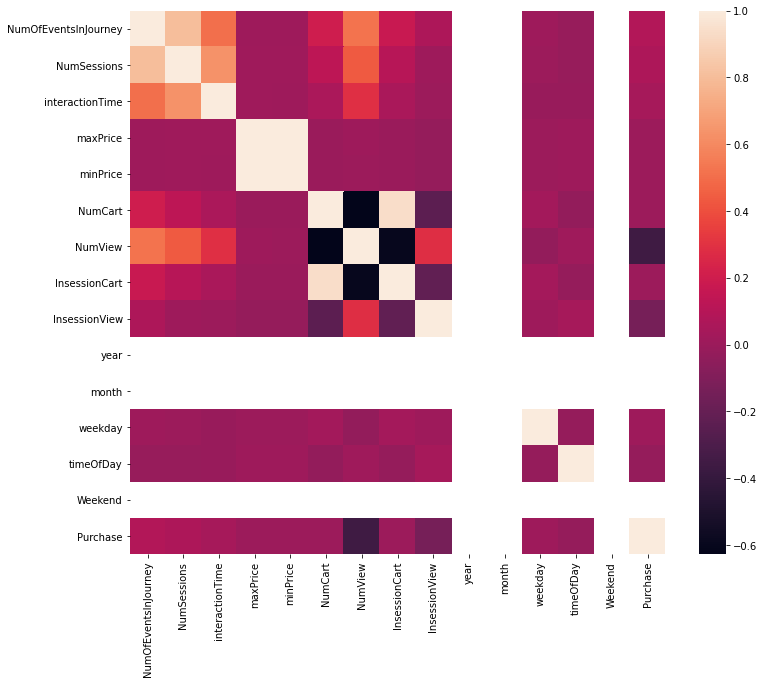

In [ ]:
#Visual inspection of features
plt.figure(figsize=(12,10))
### START CODE HERE ###
# Compute the Pearson Correlation of each feature in the training df
cor = X_train.corr(method='pearson')
### END CODE HERE ###
# Plot the correlations
sns.heatmap(cor)
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

### Fill (replace) NaN values in the correlation matrix with 1 so the associated features (with no variance) can be removed

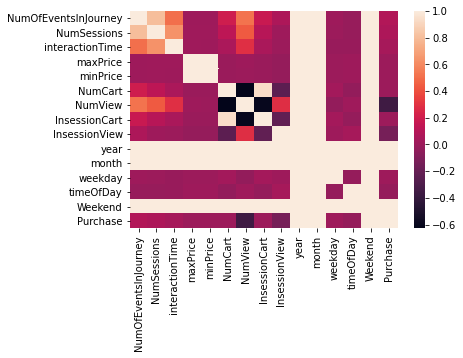

In [ ]:
### START CODE HERE ###
cor = cor.fillna(1)
sns.heatmap(cor)
plt.show()
### END CODE HERE ###

### Drop features with high correlations

In [ ]:
### START CODE HERE ###
# Initialize a list indicating whether to keep a column in the training df
# For now, set all entries to True
keep_columns = np.full((cor.shape[0],), True, dtype=bool)

# Loop over all columns
for i in range(cor.shape[0]-1):
    # Loop over all columns to the right of the current one
    for j in range(i+1, cor.shape[0]-1):
        # If the absolute correlation between the current two columns is greater than or equal to 0.8, or no correlation 0 value...
        if (np.abs(cor.iloc[i,j]) >= 0.8):
            # If we haven't already told the keep_columns list to drop column j...
            if keep_columns[j]:
                # Drop column j
                keep_columns[j] = False
# Extract the columns to keep from the training df
selected_columns = X_train.columns[keep_columns]
# Make a new df with the columns we've decided to keep from the training df
X_out = X_train[selected_columns]
### END CODE HERE ###
print('The following columns are present in the new data:')
print(selected_columns)
print(f'The old data had {X_train.shape[1]} features. The new df has {X_out.shape[1]} features.')
print(y_train.shape)
X_out.head()

The following columns are present in the new data:
Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'Purchase'],
      dtype='object')
The old data had 15 features. The new df has 7 features.
(645816,)


,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,Purchase
0,1,0.0,154.41,0,1,1,0
1,1,0.0,92.67,0,1,1,0
2,1,0.0,155.71,0,1,1,0
3,1,0.0,898.32,0,1,1,0
4,1,0.0,146.21,0,1,1,0


### Feature Selection on p-value (statistical significance to Y value)

In [ ]:
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        #maxVar = max(regressor_OLS.pvalues).astype(float)
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
# Note that we're passing in df_out, not df_train
data_modeled, selected_columns = backwardElimination(X_out.values, y_train, SL, selected_columns)

In [ ]:
print('The following columns remain based on p-value selection:')
print(selected_columns)
# Make a reduced df
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(f'After selection by Pearson Correlation, we had {X_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'Purchase'],
      dtype='object')
After selection by Pearson Correlation, we had 7 features.
After selection by p-value, we have 7 features.


### Visualize the selected features

Ignore the warning messages about distplot. I should replace it with displot, but I haven't figured out how to overlay plots with it.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

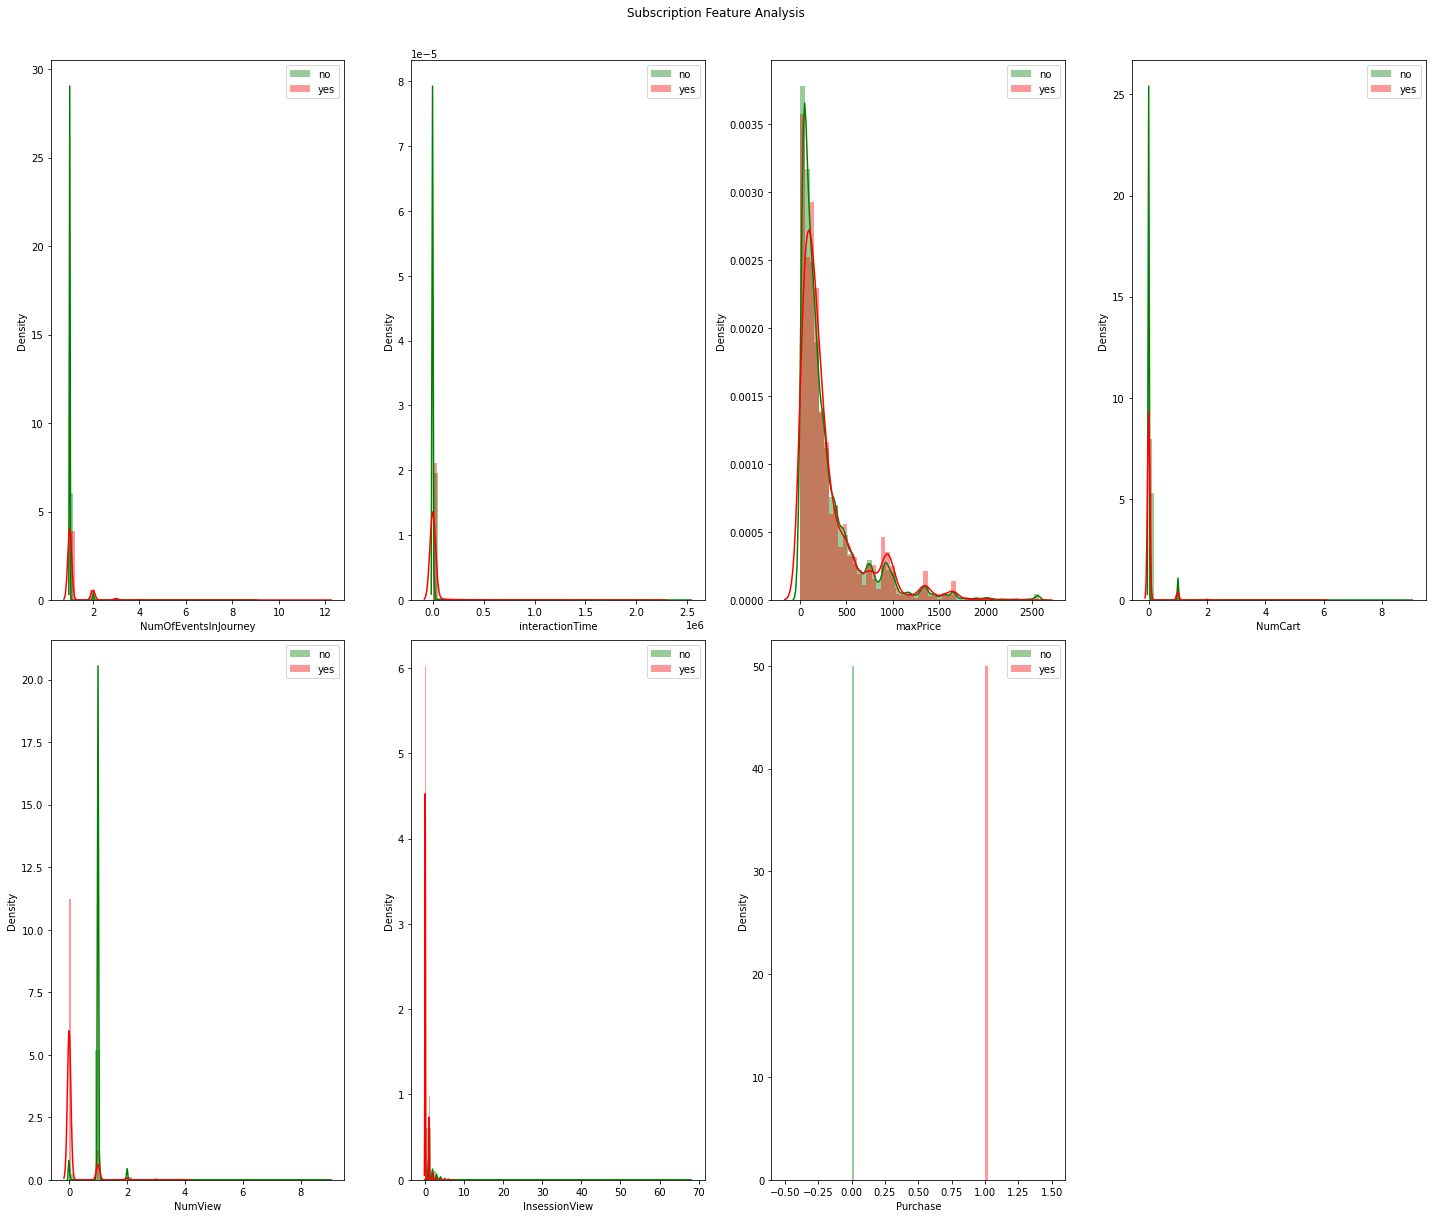

In [ ]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_red.columns:
    plt.subplot(3, 4, j+1)
    j += 1
    sns.distplot(data_red[i][data_red['Purchase']==0], color='g', label = 'no')
    sns.distplot(data_red[i][data_red['Purchase']==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Drop purchase from the features of X_train and X_test and scale the features so the max norm of each feature is 1. Also, convert the X DataFrames and y Series to NumPy arrays for use with the visualization convenience function which we'll set up next.

In [ ]:
from sklearn.preprocessing import normalize
# Note that this function outputs NumPy arrays by default
### START CODE HERE ###
X_train = data_red.drop(columns='Purchase')
X_train = normalize(X_train, axis=0, norm='max')
y_train = y_train.values
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
X_test = pd.DataFrame(data = X_test, columns = selected_columns).drop(columns='Purchase')
# X_test = X_test[selected_columns].drop(columns='Purchase')
X_test = normalize(X_test, axis=0, norm='max')
y_test = y_test.values
### END CODE HERE ###
print(X_train.shape)
print(X_test.shape)

(645816, 6)
(430544, 6)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(645816,)
(430544,)


Feature ranking:
1. feature 3 (0.501193)
2. feature 4 (0.367738)
3. feature 5 (0.093052)
4. feature 0 (0.028238)
5. feature 1 (0.007418)
6. feature 2 (0.002363)


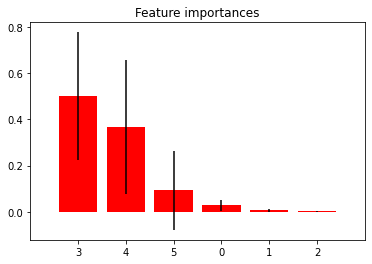

In [ ]:
#Use Random Forest to get feature ranks/importances for each feature
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


## Thus features 3 and 4 (numcart, numview) are the top two rated features that can be used to visualize. Let's set up a convenience function for this purpose.

Note that `X`, `y`, and `yhat` must be NumPy arrays for this function to work

In [ ]:
# This function visualizes the classification output on scatter plot
# Feature 1 (Interaction Time is used to observe the impact of low ranked feature)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
def visualize_scatter_plot(X, y, yhat, title):
    loc11=np.where((y>0) & (yhat>0),1,0) #TP
    loc00=np.where((y==0) & (yhat==0),1,0) #TN
    loc10=np.where((y>0) & (yhat==0),1,0) #FN
    loc01=np.where((y==0) & (yhat>0),1,0) #FP
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(X[np.where(loc00>0),3],X[np.where(loc00>0),4],X[np.where(loc00>0),1],color='blue', marker='o')
    ax.scatter3D(X[np.where(loc10>0),3],X[np.where(loc10>0),4],X[np.where(loc10>0),1],color='cyan', marker='o')
    ax.scatter3D(X[np.where(loc11>0),3],X[np.where(loc11>0),4],X[np.where(loc11>0),1],color='red', marker='^')
    ax.scatter3D(X[np.where(loc01>0),3],X[np.where(loc01>0),4],X[np.where(loc01>0),1],color='green', marker='^')
    ax.set_xlabel('NumCart')
    ax.set_ylabel('NumViews')
    ax.set_zlabel('InteractionTime')
    plt.title(title)
    plt.show()

# Task 2. Fit a linear model. Pick from SVM, LR. Report results
Ensure each model is the fitted with the best hyperparameters. That includes mitigating the effects of any class imbalances.

### Import models, metrics, and convenience functions

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

### Instantiate, train, and predict with the model

Remember to use the test data when making and evaluating the predictions

In [ ]:
### START CODE HERE ###
regb = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)
reg_predb = regb.predict(X_test)
### END CODE HERE ###

### Evaluate the predictions

Accuracy = 0.9990268125905831, Precision = 0.9440722854027107, Recall = 0.9901960784313726, F1-score = 0.9665842571177925
Confusion Matrix is:
[[424065    359]
 [    60   6060]]


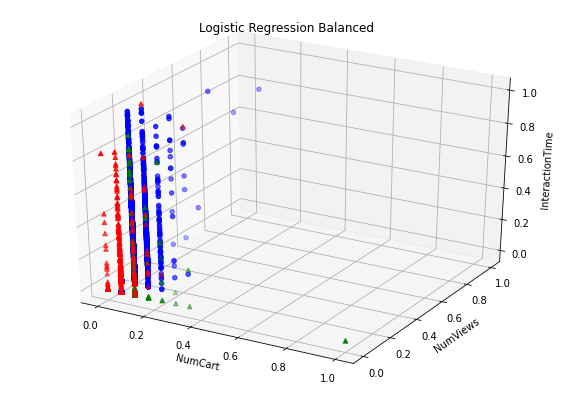

In [ ]:
### START CODE HERE ###
cmlog = confusion_matrix(y_test, reg_predb)
acc   = accuracy(y_test, reg_predb)
rec   = recall(y_test, reg_predb)
prec  = precision(y_test, reg_predb)
f1    = f1_score(y_test, reg_predb)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmlog)
visualize_scatter_plot(X_test,y_test,reg_predb,'Logistic Regression Balanced')
#No improvement

## Task 3: Fit a Non-Linear Classifier, select from NN, Random Forest, Gradient Boosted Trees

### Unless you already know to use a deep learning framework, DON'T try running an NN classifier in Colab. Scikit-Learn doesn't offer GPU support, so training one of its neural networks will take forever. Your local system might be able to exploit CPU parallelization, though.

### Instantiate, train, and predict with the model

In [ ]:
from sklearn.neural_network import MLPClassifier
### START CODE HERE ###
nn_model = MLPClassifier(solver='sgd', alpha=1e-3, hidden_layer_sizes=(15,),random_state=1)
nn_model.fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)
### END CODE HERE ###

### Evaluate the model

Accuracy = 0.9985181537775465, Precision = 0.9913947651487989, Recall = 0.9035947712418301, F1-score = 0.9454607625235083
Confusion Matrix is:
[[424376     48]
 [   590   5530]]


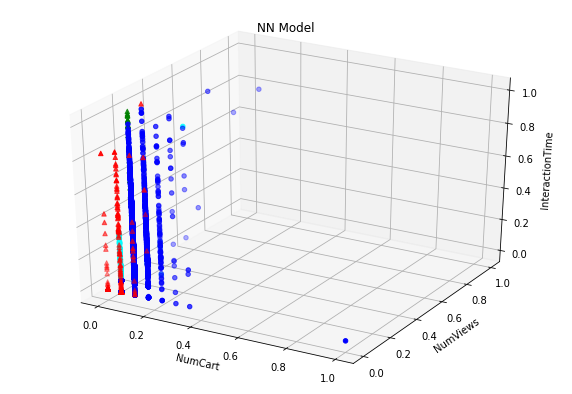

In [ ]:
### START CODE HERE ###
cmnn = confusion_matrix(y_test, nn_pred)
acc  = accuracy(y_test, nn_pred)
rec  = recall(y_test, nn_pred)
prec = precision(y_test, nn_pred)
f1   = f1_score(y_test, nn_pred)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmnn)
visualize_scatter_plot(X_test,y_test,nn_pred,'NN Model')

## Gradient Boosted Trees Model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier(random_state=1)
gbt_model.fit(X_train, y_train)
gbt_pred = gbt_model.predict(X_test)

Accuracy = 0.9990802333791668, Precision = 0.9542857142857143, Recall = 0.9823529411764705, F1-score = 0.9681159420289855
Confusion Matrix is:
[[424136    288]
 [   108   6012]]


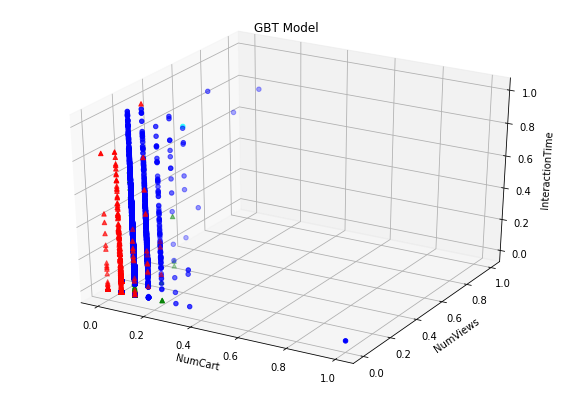

In [ ]:
### START CODE HERE ###
cmgbt = confusion_matrix(y_test, gbt_pred)
acc  = accuracy(y_test, gbt_pred)
rec  = recall(y_test, gbt_pred)
prec = precision(y_test, gbt_pred)
f1   = f1_score(y_test, gbt_pred)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmgbt)
visualize_scatter_plot(X_test,y_test,gbt_pred,'GBT Model')

## Task 4: Analyze importace of data sample balancing using Random forest and visualize Decision Tree

### Instantiate, train, predict with, and evaluate an unbalanced random forest classifier

Accuracy = 0.9980652383960756, Precision = 1.0, Recall = 0.8638888888888889, F1-score = 0.9269746646795828
Confusion Matrix is:
[[424424      0]
 [   833   5287]]


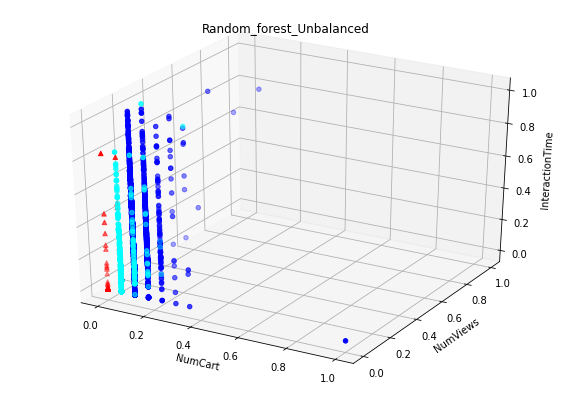

In [ ]:
### START CODE HERE ###
# Instantiate the classifier
# Set the max depth to 5 and the random state to 0
clf = RandomForestClassifier(max_depth=5, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(X_test)
# Compute the confusion matrix and evaluation metrics
cm = confusion_matrix(y_test, prediction)
acc  = accuracy(y_test, prediction)
rec  = recall(y_test, prediction)
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test, y_test, prediction, 'Random_forest_Unbalanced')

### Repeat the previous exercise, but this time, incorporate class-balanced penalty weights

Accuracy = 0.9986807387862797, Precision = 0.9248546066727885, Recall = 0.9874183006535948, F1-score = 0.9551130077445867
Confusion Matrix is:
[[423933    491]
 [    77   6043]]


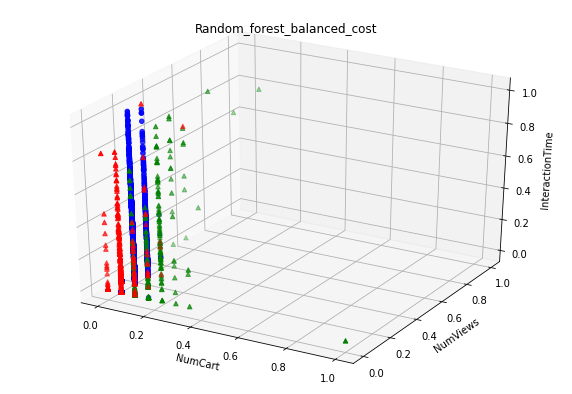

In [ ]:
### START CODE HERE ###
# Instantiate the classifier
# Set the max depth to 5 and the random state to 0
clf = RandomForestClassifier(max_depth=5, random_state=0, class_weight='balanced')
# Train the classifier
clf.fit(X_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(X_test)
# Compute the confusion matrix and evaluation metrics
cm = confusion_matrix(y_test, prediction)
acc  = accuracy(y_test, prediction)
rec  = recall(y_test, prediction)
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test,y_test,prediction,'Random_forest_balanced_cost')

### Finally, subsample the data so the two classes are equally represented when training the model

DON'T try running this in Colab. You'll get the following error message: `ValueError: object of too small depth for desired array`. It does seem to work when run locally, though.

In [ ]:
!python -V

Python 3.7.10


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
### START CODE HERE ###
# Instantiate, train, and predict with the classifier
clf = BalancedRandomForestClassifier()
clf.fit(X_train, y_train)
predictionBR = clf.predict(X_test)
# Compute the confusion matrix and evaluation metrics
cm   = confusion_matrix(y_test, predictionBR)
acc  = accuracy(y_test, predictionBR)
rec  = recall(y_test, predictionBR)
prec = precision(y_test, predictionBR)
f1   = f1_score(y_test, predictionBR)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test, y_test, prediction, 'Random_forest_balanced_trees')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

ValueError: ignored

### As colab implementation of Balanced Random Classifier was not working, I worked the example out side of colab to acheive the following results. Although, these results don't seem to make sense compared to the other classifiers.

Accuracy = 0.9524764019473039, 
Precision = 0.2291800430562375, 
Recall = 0.9915032679738562, 
F1-score = 0.37230419977298523
Confusion Matrix is:
[[404015  20409]
 [    52   6068]]

In [ ]:
cols = np.array((selected_columns[:-1])).astype(str)
print(cols)

['NumOfEventsInJourney' 'interactionTime' 'maxPrice' 'NumCart' 'NumView'
 'InsessionView']


In [ ]:
print(clf.estimators_[0])

IndexError: ignored

DecisionTreeClassifier(max_features='auto', random_state=784220732)

### Visualize the decision tree

In [ ]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(clf.estimators_[0], max_depth=5, out_file='tree.dot', 
                feature_names = cols,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

IndexError: ignored

##Comment on the decision tree between balanced and unbalanced  classifiers
# Report the following:

## 1. Optimal Feature set contains X features named:
Classification performance:
-------------------------------------------------------------------
        Classifier  |Accuracy     |Precision|     Recall  | F1-score  |
-------------------------------------------------------------------------------------------
Linear Classifier    |                  |                 |                  |                  |
------------------------------------------------------------------------------------------
Non Linear Classiifer|               |                |                  |                  |
------------------------------------------------------------------------------------------


Results from various classifiers:


### Logistic Regression
Accuracy = 0.9990268125905831, Precision = 0.9440722854027107, Recall = 0.9901960784313726, F1-score = 0.9665842571177925


### NN

Accuracy = 0.9985181537775465, Precision = 0.9913947651487989, Recall = 0.9035947712418301, F1-score = 0.9454607625235083


 ## Gradient Boosting

Accuracy = 0.9990802333791668, Precision = 0.9542857142857143, Recall = 0.9823529411764705, F1-score = 0.9681159420289855



## Random Forest Classifier (unbalanced)

Accuracy = 0.9980652383960756, Precision = 1.0, Recall = 0.8638888888888889, F1-score = 0.9269746646795828


## Random Forest Classifier (Balanced)
Accuracy = 0.9986807387862797, Precision = 0.9248546066727885, Recall = 0.9874183006535948, F1-score = 0.9551130077445867


In the above run classifiers, the best F-1 Score is for gradient boosting technique, which boosts the misclassified samples and creates new decision boundary accordingly. There wasn't enough distinction between between linear and non-linear classifiers. It might due to the nature of the dataset. 

But there was a clear increase in F-1 score between unbalanced and balanced RF. 

I was not able to run the BalancedRandomForestClassifier() as it caused error in the colab notebook. 